# MS&E 234 Project Poking

Test sandbox for persuasion bandits.

## Introduction

Bayesian persuasion is a theoretical framework for understanding the impact of information provision on the actions of a rational actor (KG2011). More generally, Bayesian persuasion is part of a growing literature on information design, which studies how an "information designer" can influence the optimal behaviour of rational actors to achieve a desired objective.

I thought this meshed with two of the papers we talked about in class:

- (White & Horvitz 2010) A sort-of-null result about the impact of Google searches on beliefs
- (Dandekar, Goel, & Lee 2012) Provided theoretical results about the conditions under which certain recommendation algorithms could be polarizing.

More generally, I'm interested in thinking about the internet as an information environment on individuals' beliefs. Much of the internet can be characterized as an _information economy_ and there are thus natural (and important) questions to ask about the impact of this environment's design. We can ask questions like: to what extent can the internet be used to manipulate people's behaviour? How successful can advertising companies be in persuading customers to buy their products? Can fake news swing an election?

These are big questions, but I thought the (KG2011) framework of Bayesian persuasion could be an interesting model to use. Most of the papers about Bayesian persuasion are theoretical in nature, and explore the dynamics of different extensions to the base model (multiple senders, costly signals, multiple receivers, etc.). In the spirit of thinking about information design in a fully online setting, I wanted to see if a multi-armed bandit could learn an optimal policy to influence the behaviour of rational agents. 

## Bayesian Persuasion: An Overview

The notation used in this literature is messy, but for the sake of completeness here we go.

The basic Bayesian persuasion framework is a one-shot game with two players: a Sender, who designs the information environment, and a Receiver, who chooses an action based on theri beliefs about the state of the world. 

The Receiver has utility function $u(a,\omega)$ evaluated over their action $a \in A$ and the state of the world $\omega \in \Omega$. The Sender has utility function $v(a, \omega)$ dependent on Receiver's action $a$ and the state of the world. Sender and Receiver share a prior distribution $\mu_0 \in \Delta(\Omega)$. The Sender can choose to send a signal to the Receiver. Let $S$ be a finite set of signal realizations. The Sender's signal is a map $\pi: \Omega \to \Delta(S)$ from the state space to the distribution over signal realizations. In other words, a signal $\pi$ specifies a statistical relationship between the state of the world ($\omega \in \Omega$) and data ($s \in S$). The basic decision process is characterized by the following steps:

1. Sender chooses a signal $\pi$
2. Receiver observes the signal
3. State $\omega$ is sampled from $\mu_0$
4. Signal realization $s$ is sampled from $\pi(\omega)$
5. Receiver observed the realized $s$
6. Receiver takes action $a$

The Sender's choice of signal $\pi$ is the main focus of the game. The Receiver, on the other hand, is assumed to be rationally Bayesian and forms their posterior after observing signal realization $s$ given their prior $\mu_0$ and the Sender's signal $\pi$:

$$
\mu_{\pi}(\omega |s) = \frac{\pi(s|\omega)\mu_0(\omega)}{\sum_{\omega'}\pi(s|\omega')\mu_0(\omega')}.
$$

Receiver then selects the action $a^*$ that maximizes their expected utility utility $u(a,\omega)$ over their posterior:

$$
a^*(\mu_{\pi}) = \arg \max_a \mathbb{E}_{\omega \sim \mu_{\pi}}u(a, \omega)
$$

The Sender, knowing that the Receiver is a rational Bayesian, chooses the optimal signal $\pi^*$ to maximize their expected utility:

$$
\pi^* = \arg \max_{\pi}\mathbb{E}_{\omega \sim \mu_0} \mathbb{E}_{s \sim \pi(\omega)}v(a^*(\mu_{\pi}), \omega)
$$

### Motivating Example

KG2011 ground their model in the simple motivating example of a prosecutor (Sender) and a judge (Receiver). The defendant in a court case can be either innocent or guilty, defining the two states of the world, $\omega \in \{ \textrm{innocent}, \textrm{guilty} \}$. The judge decides between two actions: to convict or to acquit. The judge receives utility of 1 for making the "just" decision (convict if guilty, acquit if innocent) and 0 utility otherwise. On the other hand, the prosecutor receives utility of 1 for a conviction and 0 for an acquittal. In summary: 

$$
\begin{aligned}
\Omega &= \{\text{innocent, guilty}\} \\
A &= \{\text{acquit, convict}\} \\
u(a,\omega) &= 
\begin{cases} 
1 & \text{just} \\
0 & \text{unjust}
\end{cases} \\
v(a,\omega) &= 
\begin{cases} 
1 & a = \text{convict} \\
0 & a = \text{acquit}
\end{cases}
\end{aligned}
$$

WLOG suppose that the set of signal realizations $S = \{i, g\}$, where $i$ and $g$ represent when the conclusion of an investigation suggests innocence and guilt respectively (WLOG courtesy of KG2011). Suppose the prior probability of guilt is 0.3. The optimal choice of signal for this simple example can be derived analytically:

$$
\begin{aligned} 
\pi(i \ | \  \textrm{innocent}) = \frac{4}{7} && \pi(i \  | \ \textrm{guilty}) = 0\\
\pi(g \ | \  \textrm{innocent}) = \frac{3}{7} && \pi(g \ | \  \textrm{guilty}) = 1
\end{aligned}
$$

The judge chooses to acquit if innocence is more probable under the posterior and convict otherwise. It is easy to see that the choice of optimal signal above induces the judge to convict defendants at a rate of 60%.

## Vanilla Bandits Code

In [1]:
import numpy as np
from math import log

from matplotlib import pyplot as plt

In [55]:
def ucb(q_a, n_a, t):
    """
    Function that chooses an action by upper confidence bound method
    
    INPUT:
        q_a: q function estimates
        n_a: action counts
        t: timestep
        
    OUTPUT:
        ix_0: action on the 0th axis (i.e. p(g | i))
        ix_1: action on the 1st axis (i.e. p(g | g))
    """
    c = 1  # hyperparameter; degree of exploration
    f = q_a + c * np.sqrt(log(t) / (n_a + 1))
    ix_0, ix_1 = np.unravel_index(np.argmax(f), f.shape)  # get max index in the array
    return ix_0, ix_1
    

def persuasion_bandit():
    """
    Function that runs persuasion bandits a la Kamenica 2018

    """
    n_iters = int(2*1e5)
    
    # discrete action space for now. 7 actions
    # to correspond to [GK13] optimum
    n_actions = 8
    
    # set up prior so prior[0] = mu_0(innocent), etc.
    prior = np.array([0.7, 0.3])
    posterior = np.array([0, 0], dtype=float)
    
    # initialize empty q function and action counts. axis 0 denotes choices
    # for p(g | innocent), axis 1 denotes choices for p(g | guilty).
    q_a = np.zeros((n_actions, n_actions))
    n_a = np.zeros((n_actions, n_actions))
    
    # define the reward function; 1 if the judge convicts, 0 otherwise
    r_a = lambda p: 1 if p[1] >= p[0] else 0
    
    # keep track of rewards
    reward_means = []
    batch_rewards = []  # average over 50 samples
    for t in range(1, n_iters):
        if t % 500 == 0:
            reward_means.append(np.mean(batch_rewards))
            batch_rewards = []
        
        # actions: bandit agent chooses p(g | i) and p(g | g)
        # these two probs completely characterize the distribution
        # ix_0: index (= numerator) of p(g | i), (along the 0th axis)
        # ix_1: index (= numerator) of p(g | g), (along the 1st axis)
        ix_0, ix_1 = ucb(q_a, n_a, t)
        
        # get previous estimates for q(a), n(a)
        q_old, n_old = q_a[ix_0, ix_1], n_a[ix_0, ix_1]
        
        # get signal realization probabilities
        p_gi, p_gg = np.divide([ix_0, ix_1], n_actions - 1)
        p_ii, p_ig = 1 - p_gi, 1 - p_gg
        
        # set up matrix so signal[0,0] gets you p(i | innocent), etc.
        pi = np.array([[p_ii, p_ig],[p_gi, p_gg]])
        
        # sample state of the world; 1 = guilty, 0 = innocent
        state = np.random.choice([0, 1], p=prior)
        
        # signal realization
        if state == 1:
            signal = np.random.choice([0, 1], p=[p_ig, p_gg])
        elif state == 0:
            signal = np.random.choice([0, 1], p=[p_ii, p_gi])
        
        # form posterior for each state
        denom = (pi[signal, :] @ prior)
        posterior[0] = (pi[signal, 0] * prior[0]) / denom
        posterior[1] = (pi[signal, 1] * prior[1]) / denom
        
        # get the reward
        batch_rewards.append(r_a(posterior))
        n_a[ix_0, ix_1] += 1
        q_a[ix_0, ix_1] += (r_a(posterior) - q_old) / n_a[ix_0, ix_1]
        
    return q_a, n_a, ucb(q_a, n_a, n_iters), reward_means
    
    

In [56]:
q_a, n_a, actions, rs = persuasion_bandit()

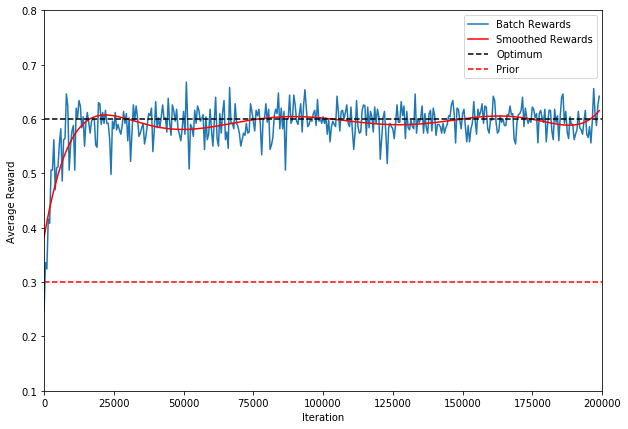

In [40]:
x = np.arange(len(rs))
line = np.poly1d(np.polyfit(x=range(len(rs)), y=np.array(rs), deg=7))
plt.figure(figsize=(10,7))
plt.plot(x*500, rs, label='Batch Rewards')
plt.plot(x*500, line(range(len(rs))), 'r-', label='Smoothed Rewards')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.axhline(0.6, linestyle='--', color='black', label='Optimum')
plt.axhline(0.3, linestyle='--', color='red', label='Prior')
plt.ylim((0.1, 0.8))
plt.xlim((0, 2*1e5))
plt.legend()
plt.show()

In [24]:
print("Optimal actions:")
print("Pr(g | innocent) = {}/7".format(actions[0]))
print("Pr(g | guilty) = {}/7".format(actions[1]))

Optimal actions:
Pr(g | innocent) = 4/7
Pr(g | guilty) = 0/7


## Multiple Receivers

Now I take a look at what would happen if there are multiple receivers who vote on the final outcome. The sender can send one signal to all three receivers, and each observe the same signal realization. The sender's priors are:

$$
\begin{aligned}
\mu_0^{(1)} &= 0.2 \\
\mu_0^{(2)} &= 0.3 \\
\mu_0^{(3)} &= 0.4
\end{aligned}
$$

Receivers observe the signal from the Sender and individually update their posteriors. The final verdict is made via majority vote. 

In [75]:
def persuasion_bandit_nreceivers():
    """
    Function that runs persuasion bandits with multiple receivers with heterogeneous
    priors. Sender can only choose _one_ signal to send to all three. Decision to
    acquit or convict is made via majority vote. 

    """
    n_iters = int(2*1e5)
    
    # discrete action space for now. 7 actions
    # to correspond to [GK13] optimum
    n_actions = 8
    
    # initialize true probability of guilt
    p_true = [0.7, 0.3]
    
    n_judges = 3
    
    # set up prior so prior[0] = mu_0(innocent), etc. for each judge
    prior = np.array([[0.7, 0.3], [0.6, 0.4], [0.8, 0.2]])
    posterior = np.zeros((n_judges, 2))
    
    # initialize empty q function and action counts. axis 0 denotes choices
    # for p(g | innocent), axis 1 denotes choices for p(g | guilty).
    q_a = np.zeros((n_actions, n_actions))
    n_a = np.zeros((n_actions, n_actions))
    
    # define the reward function; 1 if the judge convicts, 0 otherwise
    get_vote = lambda p: 1 if p >= 0.5 else 0
    
    # keep track of rewards
    reward_means = []
    batch_rewards = []  # average over 50 samples
    for t in range(1, n_iters):
        if t % 50 == 0:
            reward_means.append(np.mean(batch_rewards))
            batch_rewards = []
        
        # actions: bandit agent chooses p(g | i) and p(g | g)
        # these two probs completely characterize the distribution
        # ix_0: index (= numerator) of p(g | i), (along the 0th axis)
        # ix_1: index (= numerator) of p(g | g), (along the 1st axis)
        ix_0, ix_1 = ucb(q_a, n_a, t)
        
        # get previous estimates for q(a), n(a)
        q_old, n_old = q_a[ix_0, ix_1], n_a[ix_0, ix_1]
        
        # get signal realization probabilities
        p_gi, p_gg = np.divide([ix_0, ix_1], n_actions - 1)
        p_ii, p_ig = 1 - p_gi, 1 - p_gg
        
        # set up matrix so signal[0,0] gets you p(i | innocent), etc.
        pi = np.array([[p_ii, p_ig],[p_gi, p_gg]])
        
        # sample state of the world; 1 = guilty, 0 = innocent
        state = np.random.choice([0, 1], p=p_true)
        
        # signal realization
        if state == 1:
            signal = np.random.choice([0, 1], p=[p_ig, p_gg])
        elif state == 0:
            signal = np.random.choice([0, 1], p=[p_ii, p_gi])
        
        # form posterior for each state and judge
        for i in range(n_judges):
            denominator = pi[signal, :] @ prior[i, :]
            posterior[i, 0] = (pi[signal, 0] * prior[i, 0]) / denominator
            posterior[i, 1] = (pi[signal, 1] * prior[i, 1]) / denominator
            
        # get the judges votes
        votes = [get_vote(posterior[i, 1]) for i in range(n_judges)]
        
        # get the verdict (same as reward)
        verdict = int(sum(votes) >= 2)
        
        # update Q and N functions:
        batch_rewards.append(verdict)
        n_a[ix_0, ix_1] += 1
        q_a[ix_0, ix_1] += (verdict - q_old) / n_a[ix_0, ix_1]
        
    return q_a, n_a, ucb(q_a, n_a, n_iters), reward_means

In [76]:
q_a, n_a, actions, rs = persuasion_bandit_nreceivers()

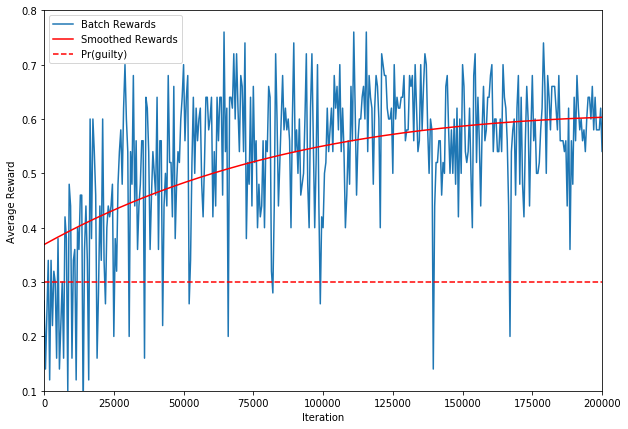

In [77]:
x = np.arange(len(rs))
line = np.poly1d(np.polyfit(x=range(len(rs)), y=np.array(rs), deg=7))
plt.figure(figsize=(10,7))
plt.plot(x*500, rs, label='Batch Rewards')
plt.plot(x*500, line(range(len(rs))), 'r-', label='Smoothed Rewards')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.axhline(0.3, linestyle='--', color='red', label='Pr(guilty)')
plt.ylim((0.1, 0.8))
plt.xlim((0, 2*1e5))
plt.legend()
plt.show()

In [78]:
actions

(3, 7)